In [6]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.cli.ncbi_gene_results_to_python import NCBIgeneToPythonCli
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
import os
from itertools import islice

import pandas as pd

In [7]:
file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
promoterpref = 'promoters_5UTR'
go_directory = f'../../data/output/{file_names}/genes/gene_ontology'
background_gene_set = f'../{promoterpref}_schmid_allfilteredgenes.txt'
NCBI_gene_list = '../../../../genes/gene_result.txt'
NCBI_gene_list_filtered = 'gene_result_filtered.txt'
#genes_of_interest = f'../{promoterpref}_czechowski_constitutive_variable_random_300.txt'
genes_of_interest = f'../{promoterpref}_schmid_constitutive_tissuespecific_random_300.txt'
variable2_name = 'tissue_specific'
author_name = 'schmid'


In [8]:
#make directory for the output files to be exported to
dirName = f'../../data/output/{file_names}/genes/gene_ontology'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/genes/gene_ontology  already exists


In [9]:
def dl_files(go_directory):
    """function to download latest ontologies and associations files from geneontology.org
    specify the directory to download the files to"""
    
    #change to go directory
    os.chdir(go_directory)
    
    # Get http://geneontology.org/ontology/go-basic.obo
    obo_fname = download_go_basic_obo()
    
    #print go file version:
    with open(obo_fname) as fin:
        for line in islice(fin, 1, 2):
            print(line)
    
    #download gene2go annotation file
    fin_gene2go = download_ncbi_associations()
    
    return obo_fname,fin_gene2go

In [10]:
def generate_background(background_gene_set, NCBI_gene_list,NCBI_gene_list_filtered):
    """function to filter the NCBI protein coding arabidopsis gene list to only include genes in my background set"""
    #load background genes
    background_df = pd.read_table(background_gene_set, sep='\t', header=0)
    
    #load NCBI gene list
    NCBI_list = pd.read_table(NCBI_gene_list, sep='\t', header=0)
    
    #Add AGI column to NCBI_list
    NCBI_list_AGI = NCBI_list.assign(AGI=NCBI_list.Aliases.str.extract(r'(.*?)\,'))
    #if NAN in the AGI column then copy the Alias column
    NCBI_list_AGI.AGI.fillna(NCBI_list.Aliases, inplace=True)
    
    #filter the NCBI gene list to the background genes of interest
    NCBI_list_filtered = NCBI_list_AGI[NCBI_list_AGI.AGI.isin(background_df.AGI)]
    #reset  index
    NCBI_list_filtered.reset_index(inplace=True, drop=True)
    
    #remove AGI column
    NCBI_list_filtered = NCBI_list_filtered[['tax_id','Org_name','GeneID','CurrentID','Status','Symbol','Aliases','description',
                                             'other_designations','map_location','chromosome','genomic_nucleotide_accession.version',
                                             'start_position_on_the_genomic_accession','end_position_on_the_genomic_accession','orientation','exon_count','OMIM']]
    
    #save file
    NCBI_list_filtered.to_csv(NCBI_gene_list_filtered,sep='\t',header=1,index=None)

    
    #convert NCBI gene tsv file to a Python module as in https://github.com/tanghaibao/goatools/blob/master/notebooks/backround_genes_ncbi.ipynb
    NCBIgeneToPythonCli().tsv_to_py(NCBI_gene_list_filtered,'genes_ncbi_3702_proteincoding.py')
       

    


In [11]:
def load_files(obo_fname,fin_gene2go):
    """function to load ontologies, associations and background gene set and then initialise a GOEA object"""
    
    #import the python module created in generate_background()
    from genes_ncbi_3702_proteincoding import GENEID2NT as GeneID2nt_ara
    
    #load ontologies
    obodag = GODag(obo_fname)
    
    #load associations
    # Read NCBI's gene2go. Store Arabidopsis thaliana annotations in a list of named tuples
    objanno = Gene2GoReader(fin_gene2go, taxids=[3702])
    # Get namespace2association where:
    #    namespace is:
    #        BP: biological_process               
    #        MF: molecular_function
    #        CC: cellular_component
    #    assocation is a dict:
    #        key: NCBI GeneID
    #        value: A set of GO IDs associated with that gene
    ns2assoc = objanno.get_ns2assc()

    for nspc, id2gos in ns2assoc.items():
        print("{NS} {N:,} annotated Arabidopsis genes".format(NS=nspc, N=len(id2gos)))
    

    
    goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_ara.keys(), # List of filtered Arabidopsis protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method
    
    return goeaobj,obodag,ns2assoc

In [12]:
def map_AGI2NCBI(NCBI_gene_list_filtered,genes_of_interest):
    """map AGI gene IDs to NCBI IDs"""
    #read in NCBI list
    NCBI_list = pd.read_table(NCBI_gene_list_filtered, sep='\t', header=0)
    
    #Add AGI column to NCBI_list
    NCBI_list_AGI = NCBI_list.assign(AGI=NCBI_list.Aliases.str.extract(r'(.*?)\,'))
    #if NAN in the AGI column then copy the Alias column
    NCBI_list_AGI.AGI.fillna(NCBI_list.Aliases, inplace=True)
    
    #read in genes of interest
    genes_of_interest_df = pd.read_table(genes_of_interest,sep='\t',header=None)
    cols = ['AGI','gene_type']
    genes_of_interest_df.columns = cols
    
    #merge the dfs
    merged = pd.merge(genes_of_interest_df, NCBI_list_AGI, how='left', on='AGI')
    
    #save the file
    merged.to_csv('mapped_NCBI_tau.tsv',sep='\t',header=True, index=False)
    
    return merged
    

In [13]:
def run_GOEA(study_genes,gene_class):
    "run Gene Ontology Enrichment Analysis. Provide study genes in dictionary key format and a gene_class string"
    #extract geneIDs
    geneids_study = study_genes
    
    #run goea
    goea_results_all = goeaobj.run_study(geneids_study)
    #filter to only significant results
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    #write to txt file
    goeaobj.wr_txt(f"{gene_class}_sig_enrichment.txt", goea_results_sig)
    
    
    
    
    #plot results
    plot_results(f"{gene_class}" + "_sig_enrichment_{NS}.png", goea_results_sig)
    

    
    return goea_results_sig,goea_results_all
    

# gene2go ----------------------------------------------------------------
           This file reports the GO terms that have been associated
            with Genes in Entrez Gene.
           It is generated by processing the gene_association files
            on the GO ftp site: 
            http://www.geneontology.org/GO.current.annotations.shtml
           and comparing the DB_Object_ID to annotation in Gene,
           as also reported in gene_info.gz

           Multiple gene_associations file may be used for any genome.
           If so, duplicate information is not reported; but unique
           contributions of GO terms, evidence codes, and citations are.
 
           The file that is used to establish the rules for 
           the files and fields that are used for each taxon 
           is documented in go_process.xml

## 1. Download Ontologies and Associations

In [14]:
obo_fname,fin_gene2go = dl_files(go_directory)

  EXISTS: go-basic.obo
data-version: releases/2020-08-11

  EXISTS: gene2go


## 2. Load Ontologies, Associations and Background gene set then initialize a GOEA object

### Load background gene set - I will use the genes in the arabidopsis genome which had coefficient of variation values from czechowski et al 2005. And I will use the list of genes after filtering 
### (only protein coding that don't overlap other protein coding genes. Only including genes whose promtoers don't 100% overlap with protein coding genes. Only genes which had at least one TFBS found in their promoters using FIMO)

I then downloaded all Arabidopsis protein coding genes from NCBI using the following search (instructions shown here https://github.com/tanghaibao/goatools/blob/master/notebooks/backround_genes_ncbi.ipynb):

"3702"[Taxonomy ID] AND alive[property] AND genetype protein coding[Properties]

I downloaded the tabular file format of all the genes (27562) on 19/08/20

I moved the file gene_result.txt to this location: data/genes/gene_result.txt

I then filtered it so it only contained genes in my own background geneset

In [15]:
#Filter NCBI gene list and create python module as in https://github.com/tanghaibao/goatools/blob/master/notebooks/backround_genes_ncbi.ipynb
generate_background(background_gene_set, NCBI_gene_list,NCBI_gene_list_filtered)

gene_result_filtered.txt genes_ncbi_3702_proteincoding.py
      13899 lines READ:  gene_result_filtered.txt
      13899 geneids WROTE: genes_ncbi_3702_proteincoding.py


In [16]:
#load files aand initialise a GOEA object
goeaobj,obodag,ns2assoc = load_files(obo_fname,fin_gene2go)

go-basic.obo: fmt(1.2) rel(2020-08-11) 47,277 GO Terms
HMS:0:00:02.542660 170,105 annotations, 28,331 genes,  7,427 GOs, 1 taxids READ: gene2go 
CC 24,581 annotated Arabidopsis genes
BP 16,726 annotated Arabidopsis genes
MF 16,337 annotated Arabidopsis genes

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 66%  9,109 of 13,899 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 91% 12,670 of 13,899 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 65%  9,037 of 13,899 population items found in association


## 4. Read study genes

In [17]:
#map AGI gene ID to NCBI gene ID
study_genes = map_AGI2NCBI(NCBI_gene_list_filtered,genes_of_interest)

#select gene_types of interest
constitutive_genes = study_genes[study_genes.gene_type == 'constitutive']
variable_genes = study_genes[study_genes.gene_type == variable2_name]

#make dictionary where key is geneid and value is gene symbol
constitutive_geneid2symbol = dict(zip(constitutive_genes.GeneID,constitutive_genes.Symbol))
variable_geneid2symbol = dict(zip(variable_genes.GeneID,variable_genes.Symbol))

#get NCBI gene ids in dictionary format
constitutive_NCBI_IDs = constitutive_geneid2symbol.keys()
variable_NCBI_IDs = variable_geneid2symbol.keys()



## 5. Run Gene Ontology Enrichment Analysis (GOEA) using Benjamini/Hochberg FDR correction

In [18]:
#keep only significant results
constitutive_goea_sig,constitutive_goea_all = run_GOEA(constitutive_NCBI_IDs,f'constitutive_{author_name}')


Run BP Gene Ontology Analysis: current study set of 300 IDs ... 80%    240 of    300 study items found in association
100%    300 of    300 study items found in population(13899)
Calculating 3,297 uncorrected p-values using fisher_scipy_stats
   3,297 GO terms are associated with  9,109 of 13,899 population items
     445 GO terms are associated with    240 of    300 study items
  METHOD fdr_bh:
      13 GO terms found significant (< 0.05=alpha) ( 12 enriched +   1 purified): statsmodels fdr_bh
      89 study items associated with significant GO IDs (enriched)
       3 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 300 IDs ... 97%    291 of    300 study items found in association
100%    300 of    300 study items found in population(13899)
Calculating 690 uncorrected p-values using fisher_scipy_stats
     690 GO terms are associated with 12,670 of 13,899 population items
     183 GO terms are associated with    291 of    

In [19]:
variable_goea_sig,variable_goea_all = run_GOEA(variable_NCBI_IDs,f'{variable2_name}_{author_name}')


Run BP Gene Ontology Analysis: current study set of 300 IDs ... 64%    192 of    300 study items found in association
100%    300 of    300 study items found in population(13899)
Calculating 3,297 uncorrected p-values using fisher_scipy_stats
   3,297 GO terms are associated with  9,109 of 13,899 population items
     224 GO terms are associated with    192 of    300 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
      12 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 300 IDs ... 89%    268 of    300 study items found in association
100%    300 of    300 study items found in population(13899)
Calculating 690 uncorrected p-values using fisher_scipy_stats
     690 GO terms are associated with 12,670 of 13,899 population items
      49 GO terms are associated with    268 of    

In [20]:
#plot colouring by significance - constitutive
# GO terms colored by P-value:

#     pval < 0.005 (light red)
#     pval < 0.01 (light orange)
#     pval < 0.05 (yellow)
#     pval > 0.05 (grey) Study terms that are not statistically significant
plot_gos("constitutive_300genes_gene_counts_tau.pdf",
         ['GO:0006886','GO:0000139','GO:0006898'], # Source GO ids
         obodag,
         goea_results=constitutive_goea_all) # Use pvals for coloring

    3 usr  26 GOs  WROTE: constitutive_300genes_gene_counts_tau.pdf


In [21]:
#plot colouring by significance - constitutive and add gene names
# GO terms colored by P-value:

#     pval < 0.005 (light red)
#     pval < 0.01 (light orange)
#     pval < 0.05 (yellow)
#     pval > 0.05 (grey) Study terms that are not statistically significant
plot_gos("constitutive_300genes_tau.pdf",
         ['GO:0006886','GO:0000139','GO:0006898'], # Source GO ids
         obodag,
         goea_results=constitutive_goea_all,
        id2symbol=constitutive_geneid2symbol,
        study_items=8, # Only only 8 gene Symbols max on GO terms
        items_p_line=4, # Print 3 genes per line) # Use pvals for coloring
        )

    3 usr  26 GOs  WROTE: constitutive_300genes_tau.pdf


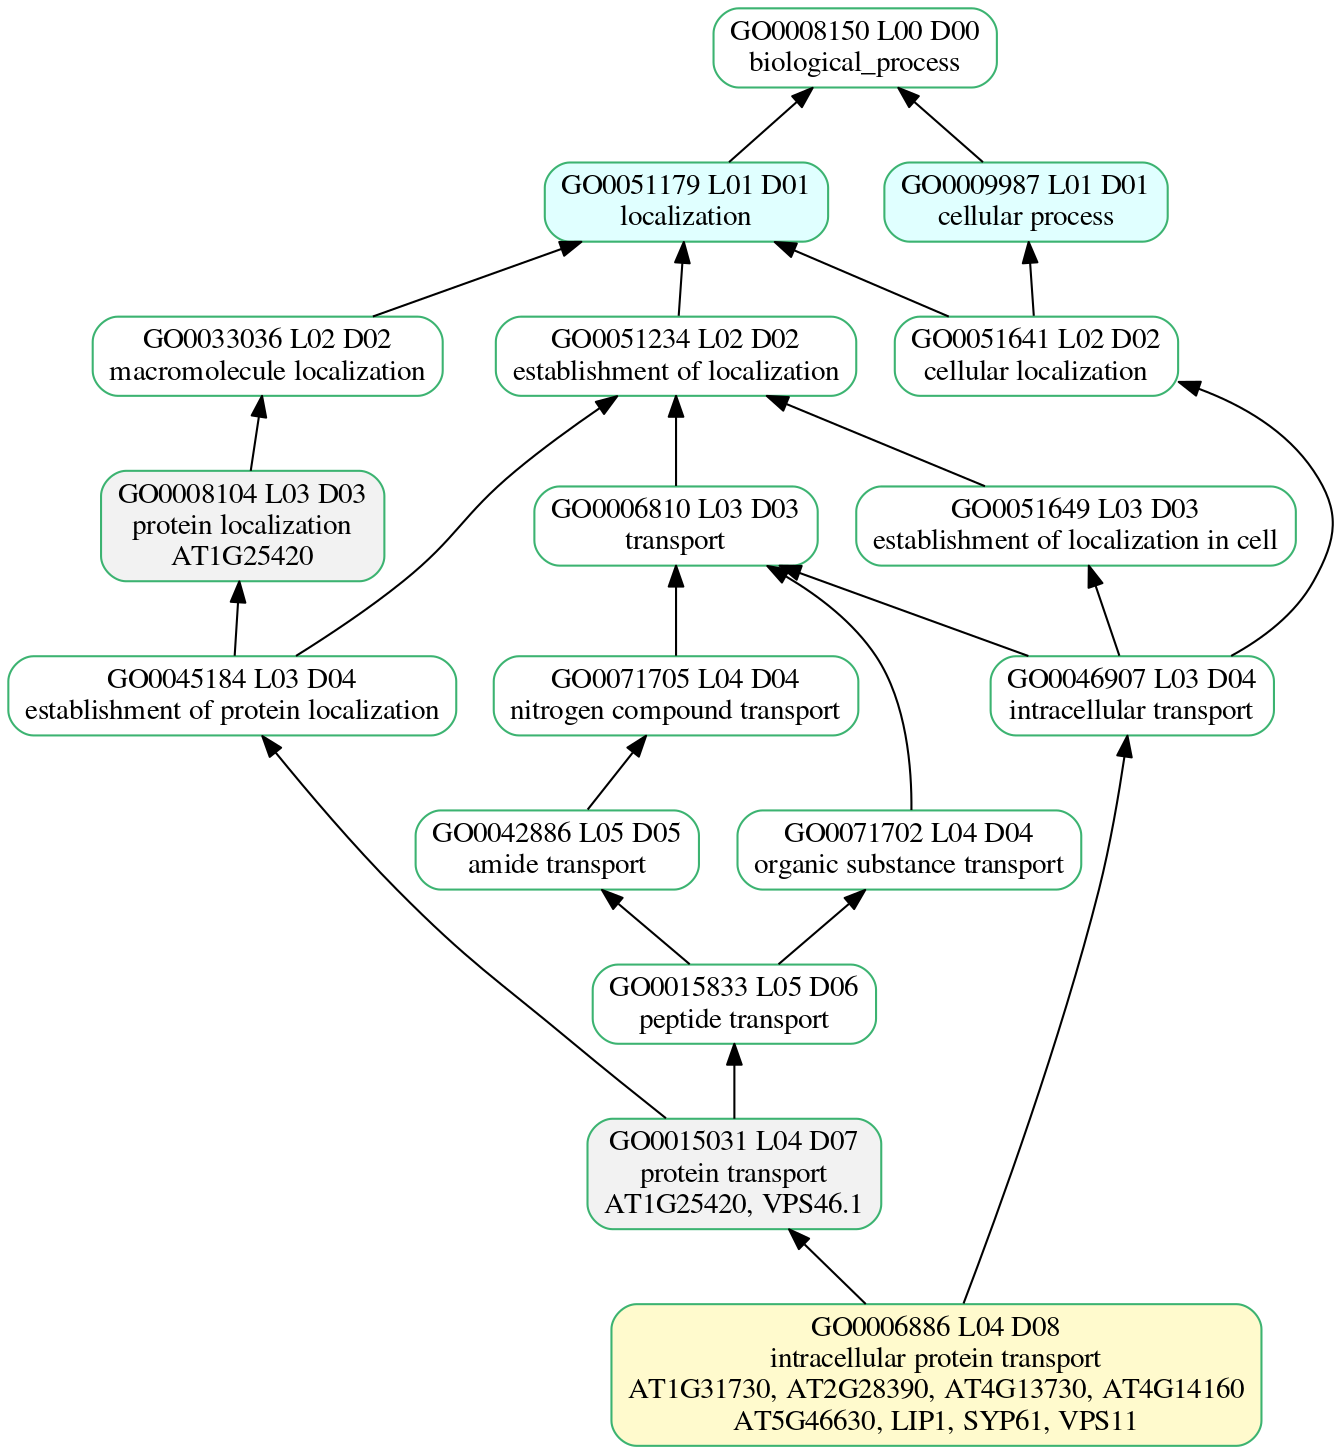

In [22]:
#plot colouring by significance - variable
# GO terms colored by P-value:

#     pval < 0.005 (light red)
#     pval < 0.01 (light orange)
#     pval < 0.05 (yellow)
#     pval > 0.05 (grey) Study terms that are not statistically significant
plot_gos(f"{variable2_name}_300genes_gene_counts_tau.pdf",
         ['GO:0005576','GO:0005829','GO:0005634','GO:0009536'], # Source GO ids
         obodag,
         goea_results=variable_goea_all) # Use pvals for coloring


#plot colouring by significance - variable and add gene names
# GO terms colored by P-value:

#     pval < 0.005 (light red)
#     pval < 0.01 (light orange)
#     pval < 0.05 (yellow)
#     pval > 0.05 (grey) Study terms that are not statistically significant
plot_gos(f"{variable2_name}_300genes_tau.pdf",
         ['GO:0005576','GO:0005829','GO:0005634','GO:0009536'], # Source GO ids
         obodag,
         goea_results=variable_goea_all,
        id2symbol=variable_geneid2symbol,
        study_items=8, # Only only 8 gene Symbols max on GO terms
        items_p_line=4, # Print 3 genes per line) # Use pvals for coloring
        )

    4 usr  10 GOs  WROTE: tissue_specific_300genes_gene_counts_tau.pdf
    4 usr  10 GOs  WROTE: tissue_specific_300genes_tau.pdf
